In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score

# Do not show warnings
import warnings
warnings.filterwarnings("ignore")

#Read the csv file
df=pd.read_csv('df_wrangled_2.csv',low_memory=False)

In [4]:
# Create feature dataframe and response variable series
X = df.drop('loan_status',axis=1) # Feature dataframe
y = df.loc[:,'loan_status'] #Response variable

In [5]:
# Convert categorical features to dummy variables and drop one column of each feature
X_dummy = pd.get_dummies(X,drop_first=True)

# Convert response variable to dummy variables and keep only charged off column
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.loc[:,'Charged Off']

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size=0.25,random_state=21, stratify=y)

In [7]:
# Print shape of X_train
X_train.shape

(949963, 136)

In [8]:
# 3 stratified folds are defined to be used as cross-validation splitting strategy. Since the training set is quite large 
# 3-fold is used instead of typical 5-fold strategy to speed up the cross validation processes.
kfolds = StratifiedKFold(n_splits=3,random_state=21) 

In [9]:
# Define imputer with median strategy and standard scaler
imputer = SimpleImputer(strategy = 'median')
scaler = StandardScaler()

In [10]:
# Show the ratio of paid-off (0) and charged-off (1) loans in the training set
y_test.value_counts(normalize=True)

0    0.798854
1    0.201146
Name: Charged Off, dtype: float64

#### The machine learning process starts with logistic regression because of its simplicity. Scikit learn recommends to use stochastic gradient descent (SGD) for large scale data. The downside of SGD is it requires tuning several parameters to provide good results. Therefore, it is decided to use logistic regression but with ‘sag’ solver which is stochastic average gradient descent. The data set must be scaled before using the ‘sag’ solver. The model is built by deploying a pipeline of imputer, scaler, and classifier. 

In [10]:
# Define logistic regression. Set random state to 21. Set solver to sag because the data set is quite large and sag is faster
clf = LogisticRegression(solver='sag',random_state=21)

# define the pipeline. 
pipeline = make_pipeline(imputer,scaler,clf)

# Two metrics are used to evaluate performance of the model: accuracy and recall.
scores = cross_validate(pipeline,X_train,y_train,cv=kfolds,scoring=['accuracy','recall'])

In [11]:
# Print the average of results
print('The average of 3-fold cross-validation accuracy scores for the logistic regression with no weighted sampling \
is %.3f'%np.mean(scores['test_accuracy']))
print('The average of 3-fold cross-validation recall scores for the logistic regression with no weighted sample \
is %.3f'%np.mean(scores['test_recall']))

The average of 3-fold cross-validation accuracy scores for the logistic regression with no weighted sampling is 0.803
The average of 3-fold cross-validation recall scores for the logistic regression with no weighted sample is 0.096


#### Due to imbalanced data which is 20% charged-off and 80% paid-off, the default classifier classifies majority of loan as paid off. Therefore, the accuracy is almost equal to the ratio of paid-off to all loans; this makes the recall score very poor.

In [12]:
# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# define the pipeline
pipeline = make_pipeline(imputer,scaler,clf)

# Run cross-validation with accuracy and recall scroing
scores = cross_validate(pipeline,X_train,y_train,cv=kfolds,scoring=['accuracy','recall'])

In [13]:
# Print the average of results
print('The average of 3-fold cross-validation accuracy scores for the logistic regression with balanced weight is %.3f '
        %np.mean(scores['test_accuracy']))
print('The average of 3-fold cross-validation recall scores for the logistic regression with balanced weight is %.3f '
        %np.mean(scores['test_recall']))

The average of 3-fold cross-validation accuracy scores for the logistic regression with balanced weight is 0.654 
The average of 3-fold cross-validation recall scores for the logistic regression with balanced weight is 0.676 


#### Due to adding balanced weight to samples, significant improvement on recall is achieved but accuracy dropped.

In [14]:
# Tune parameter C

# Define LogisticRegressionCV with recall scoring. Recall is chosen because it is more important 
# to predict charged-off loans than the paid-off ones.
clf=LogisticRegressionCV(Cs=np.logspace(-2,2,5),class_weight='balanced',solver='sag',cv=kfolds,scoring='recall',random_state=21)

# define the pipeline
pipeline = make_pipeline(imputer,scaler,clf)

# Fit the pipeline to the training set
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])...    random_state=21, refit=True, scoring='recall', solver='sag',
           tol=0.0001, verbose=0))])

In [15]:
# Access to LogisticRegressionCV
regcv = pipeline.steps[2][1]

# Print the best C
print('Best C is ',regcv.C_)

# Print the average of score for each C value
print('The average of the three scores for each C value:\n',regcv.scores_[1].mean(axis=0))

Best C is  [100.]
The average of the three scores for each C value:
 [0.6761041  0.67616166 0.6761983  0.676214   0.6762454 ]


#### Although the best C value is 100, the average of three scores across the five C values are within less than 0.001 of each other. Therefore, the default value C=1 will be kept. 

In [15]:
# Add interaction features. There are 136 features after transforming categorical features. Interaction between all of them
# make the model too complex. Therefore, a feature selection is added before interaction.

# Define feature selector. Select 25 features with highest chi2 scores which is more than one-third of the number of features 
# before transforming categorical features

feature_selector = SelectKBest(chi2, k=25)

# Define interaction terms
interaction = PolynomialFeatures(degree = 2,interaction_only=True)

# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# Define pipeline
pipeline = make_pipeline(imputer,feature_selector,interaction,scaler,clf)

# Run cross-validation 
scores = cross_val_score(pipeline,X_train,y_train,cv=kfolds,scoring='recall')

#print results
print('The average of 3-fold cross-validation recall scores for the logistic regression with interaction terms is %.3f '
      %np.mean(scores))

The average of 3-fold cross-validation recall scores for the logistic regression with interaction terms is 0.661 


#### The average of cross validation score slightly dropped. Therefore, interaction term did not improve the model.

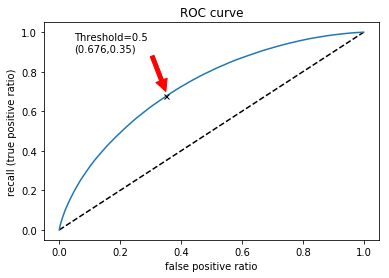

In [16]:
# Plot ROC curve for the training data set

# Classifier
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# Pipeline
pipeline = make_pipeline(imputer,scaler,clf)

# Fit pipeline to training set
pipeline.fit(X_train,y_train)

# Compute probability estimates
y_predict_proba = pipeline.predict_proba(X_train)

# Compute true positive ratio (recall) and false positive ratio
fpr, tpr, thresholds = roc_curve(y_train,y_predict_proba[:,1])

# Find the false positive ratio corresponding to recall 0.676
a = np.argwhere(np.round(tpr,3)==0.676)[0]
b = np.float(fpr[a])

# Plot ROC curve and the point corresponding to threshold  = 0.5
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.plot(b,0.676,marker='x',markersize=5,color='black')
plt.annotate('Threshold=0.5 \n(0.676,%.2f)'%b,(b,0.7),(0.05,0.9),arrowprops={'color':'red'})
plt.xlabel('false positive ratio')
plt.ylabel('recall (true positive ratio)')
plt.title('ROC curve')
plt.show()

#### Raising the threshold to increase recall in the expense of increasing false positive ratio is a business decision, but in my opinion, false positive ratio of 0.35 is already too high because it means more than one-third of eligible applicants are labeled as charged-off. Therefore, the threshold will bnot be raised.

####  Other feature engineering could be also tested, but it is preferred to develop a XGBoost model instead because logistic regression has limited capacities compared to XGBoost and there is a good chance its performance will not improve.

#### Conclusion: The final logistic regression classifier has the following parameters: class_weight='balanced', solver='sag', and C=1. The average of 3-fold cross-validation accuracy and recall scores for this classifier are 0.654 and 0.676, respectively.

# XGBoost Classifier

In [17]:
# Define classifier 
clf = XGBClassifier(scale_pos_weight=4,random_state=21)

# Run cross validation
scores = cross_validate(clf,X_train,y_train,cv=kfolds,scoring=['accuracy','recall'])

In [18]:
# Print the average of results
print('The average of 3-fold cross-validation accuracy scores for the XGBoost classifier is %.3f '
      %np.mean(scores['test_accuracy']))
print('The average of 3-fold cross-validation recall scores for the XGBoost classifier is %.3f '
        %np.mean(scores['test_recall']))

The average of 3-fold cross-validation accuracy scores for the XGBoost classifier is 0.666 
The average of 3-fold cross-validation recall scores for the XGBoost classifier is 0.694 


#### Both accuracy and recall scores improved compared to the logistic regression classifier.

#### In order to improve the recall score, five parameters are tuned based on the mentioned values: n_estimators: {20,50,100}, learning_rate: {0.05,0.1,0.2}, max_depth: {3,4,5}, subsample:{0.6,0.8,1}, and colsample_bytree:{0.4,0.7,1}. Since the dataset is quite large, the parameters are tuned one by one. The process starts with number of estimators and assign the rest of parameters to the middle value of their corresponding set.

In [11]:
# Define a function which receives classifier, parameter values, cross-validation folds, and features and response 
# variable of training set as inputs, tune hyper parameters and prints the best score and best parameter value

def tuning(classifier,param_set,cv_folds=kfolds,train_feature=X_train,train_response=y_train):
    model = GridSearchCV(classifier,param_grid=param_set,cv=cv_folds,scoring='recall') 
    model.fit(train_feature,train_response)
    print('The best score in parameter tuning is: %.3f'%model.best_score_)
    print('The best parameter value is: ',model.best_params_)    
    return model

In [22]:
# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,learning_rate=0.1,max_depth=4,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'n_estimators':[20,50,100]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.698
The best parameter value is:  {'n_estimators': 100}


In [23]:
# Print the mean of test scores for each value of n_estimators 
cv.cv_results_['mean_test_score']

array([0.69403871, 0.69567151, 0.69805791])

In [24]:
# Score goes up very slowly.Therefore, n_estimators beyond 100 will not be tested. 
# Tune learning_rate

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,max_depth=4,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'learning_rate':[0.05,0.1,0.2]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.699
The best parameter value is:  {'learning_rate': 0.2}


In [25]:
# Print the mean of test scores for each value of learning_rate 
cv.cv_results_['mean_test_score']

array([0.69533658, 0.69805791, 0.69913598])

In [26]:
# Score goes up very slowly. Therefore, learning_rate beyond 0.2 will not be tested. 
# Tune max_depth.

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'max_depth':[3,4,5]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.699
The best parameter value is:  {'max_depth': 4}


In [27]:
# Print the mean of test scores for each value of max_depth
cv.cv_results_['mean_test_score']

array([0.69815211, 0.69913598, 0.69849752])

In [28]:
# max_depth = 4
#Tune subsample

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,max_depth=4,colsample_bytree=0.7)

# Define parameter
parameter = {'subsample':[0.6,0.8,1]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.699
The best parameter value is:  {'subsample': 0.8}


In [29]:
# Print the mean of test scores for each value of subsample 
cv.cv_results_['mean_test_score']

array([0.69870161, 0.69913598, 0.69907318])

In [30]:
# subsample = 0.8
# Tune colsample_bytree

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,max_depth=4,subsample=0.8)

# Define parameter
parameter = {'colsample_bytree':[0.4,0.7,1]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.700
The best parameter value is:  {'colsample_bytree': 0.4}


In [31]:
# Print the mean of test scores for each value of colsample_bytree
cv.cv_results_['mean_test_score']

array([0.69961744, 0.69913598, 0.69878533])

In [12]:
# The best score belongs to 0.4. colsample_bytree is Subsample ratio of columns when constructing each tree. 
# Therefore, lower value of the parameter make the process of model building faster and it is worth checking the 3-fold 
# cross-validation recall score of values lower than 0.4.

# Define parameter
parameter = {'colsample_bytree':[0.1,0.2,0.3]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.699
The best parameter value is:  {'colsample_bytree': 0.3}


In [13]:
# Print the mean of test scores for each value of colsample_bytree
cv.cv_results_['mean_test_score']

array([0.69491792, 0.69636755, 0.69893188])

In [17]:
# Scores go up very slowly as the parameter value goes down. Therefore,colsample_bytree below 0.4 will not be tested. 

# The classifier with tuned parameters is below.
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,max_depth=4,subsample=0.8
                    ,colsample_bytree=0.4)

# Build the model by pipelining imputer and classifier
pipeline = make_pipeline(imputer,clf)

# Fit the pipeline to the training set
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_d...e=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
       seed=None, silent=True, subsample=0.8))])

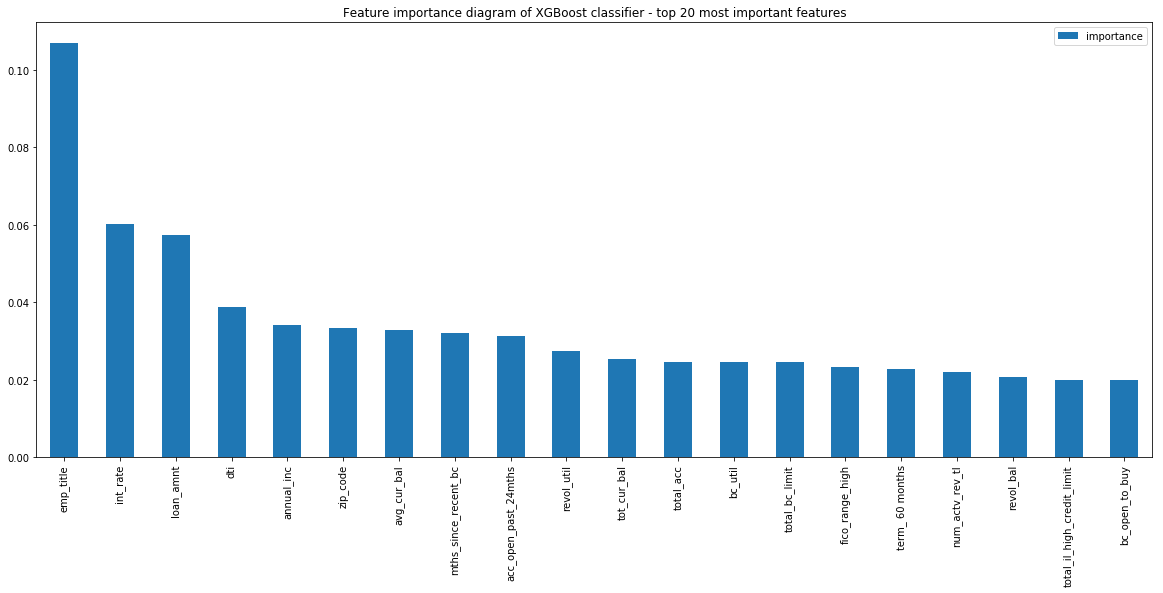

In [18]:
# Plot the feature importance diagram of top 20 most important features.
features = pd.DataFrame(pipeline.steps[1][1].feature_importances_, index = X_train.columns,
                            columns=['importance']).sort_values('importance',ascending=False)
features.iloc[:20].plot.bar(figsize=(20,8))
plt.title ('Feature importance diagram of XGBoost classifier - top 20 most important features')
plt.show()

In [35]:
# As the diagram above is showing, emp_title and zip_code are first and sixth most important features.
# Since the two features were originally categorical variables and were transformed to numerical ones, it is worth 
# checking if removing them improves the performance of the model

X_train_new = X_train.drop(['emp_title','zip_code'],axis=1)

# Run cross-validation score
scores = cross_val_score(pipeline,X_train_new,y_train,cv=kfolds,scoring='recall')

# Print the average of results
print('The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing employment title \
and zip code \nis %.3f'%np.mean(scores))

The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing employment title and zip code 
is 0.681


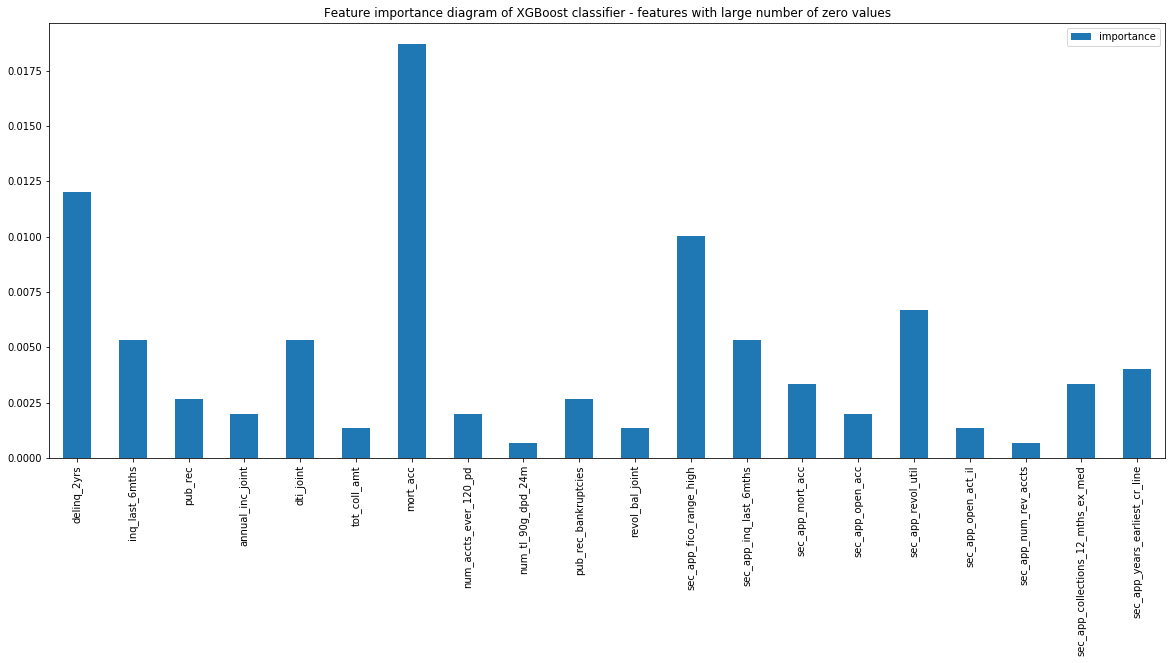

In [19]:
# The average recall score dropped. Therefore, the two features will be kept in the final model.

# It was shown in EDA2 that some numerical features have quite large number of zeros. It is worth investigating
# if these features have negatively impacted performance of the XGBoost.

# First, the feature importance diagram of these features is plotted

# Create list of median values of numerical features
a = X.loc[:,X.dtypes[X.dtypes=='float64'].index].median()

# Create list of numerical features with median less than 1
feature_list = np.array(a[a<=1].index).tolist()

# Plot the feature importance diagram
features.loc[feature_list].plot.bar(figsize=(20,8))
plt.title ('Feature importance diagram of XGBoost classifier - features with large number of zero values')
plt.show()

In [37]:
# The importance of some features is high to some extent.

# Drop features in feature_list from training set
X_train_new = X_train.drop(feature_list,axis=1)

# Run cross-validation score
scores = cross_val_score(pipeline,X_train_new,y_train,cv=kfolds,scoring='recall')

# Print the average of results
print('The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing features with \
many zero values is %.3f'%np.mean(scores))

The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing features with many zero values is 0.699


In [24]:
# Removing the features with many zero values did not improve the recall score. Therefore, they will be kept for now.

# Improving the recall score of the classifier stops here. 
# Now the model is simplified by keeping the important features and removing the rest

# Create a list of features with importance higher than 0
feature_keep = features.loc[features.importance>0].index

# Print the number of important features
print('The number of features with importance more than 0 is ',len(feature_keep))

The number of features with importance more than 0 is  95


In [25]:
# Remove unimportant features
X_train_new = X_train.loc[:,feature_keep]

# Run cross-validate score to make sure performance of the model did not decrease
scores = cross_validate(pipeline,X_train_new,y_train,cv=kfolds,scoring=['recall','accuracy'])

# Print the results
print('The average of 3-fold cross-validation accuracy scores for the XGBoost classifier after removing unimportant features is %.3f '
        %np.mean(scores['test_accuracy']))
print('The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing unimportant features is %.3f '
        %np.mean(scores['test_recall']))

The average of 3-fold cross-validation accuracy scores for the XGBoost classifier after removing unimportant features is 0.675 
The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing unimportant features is 0.699 


### Find the accuracy and recall scores of the test set.

In [26]:
# Fit the pipeline on the new training set
pipeline.fit(X_train_new,y_train)

# Remove the unimportant features from the feature dataframe of the test set 
X_test_new = X_test.loc[:,feature_keep]

# Predict the response variable of the test set
y_predict = pipeline.predict(X_test_new)

# Print recall and accuracy scores of the test set
print('The accuracy score of the test set is %.3f'%accuracy_score(y_test,y_predict))
print('The recall score of the test set is %.3f'%recall_score(y_test,y_predict))

The accuracy score of the test set is 0.673
The recall score of the test set is 0.704


### Accuracy score of the test set is 0.002 lower than the average of 3-fold cross-validation  scores of the training set, but the recall score is 0.005 higher than the corresponding score of the training set.